Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



C:\Users\Administrator\anaconda3\envs\tf2\lib\site-packages\skopt\sampler\sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+25002=25002. 
  total_n_samples))


Compiling model...
Building feed-forward neural network...
'build' took 0.057823 s



C:\Users\Administrator\anaconda3\envs\tf2\lib\site-packages\skopt\sampler\sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+3002=3002. 
  total_n_samples))
C:\Users\Administrator\anaconda3\envs\tf2\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:110: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,
C:\Users\Administrator\anaconda3\envs\tf2\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


'compile' took 4.343280 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [7.96e+01, 1.35e+00]    [7.96e+01, 1.35e+00]    []  
1000      [2.88e-01, 2.88e+00]    [2.88e-01, 2.88e+00]    []  
2000      [3.50e-01, 2.73e+00]    [3.50e-01, 2.73e+00]    []  
3000      [4.21e-01, 2.62e+00]    [4.21e-01, 2.62e+00]    []  
4000      [4.47e-01, 2.56e+00]    [4.47e-01, 2.56e+00]    []  
5000      [4.69e-01, 2.50e+00]    [4.69e-01, 2.50e+00]    []  
6000      [4.95e-01, 2.41e+00]    [4.95e-01, 2.41e+00]    []  
7000      [4.81e-01, 1.81e+00]    [4.81e-01, 1.81e+00]    []  
8000      [2.54e-01, 2.68e-01]    [2.54e-01, 2.68e-01]    []  
9000      [5.93e-02, 2.84e-02]    [5.93e-02, 2.84e-02]    []  
10000     [1.83e-02, 5.18e-03]    [1.83e-02, 5.18e-03]    []  
11000     [8.29e-03, 2.24e-03]    [8.29e-03, 2.24e-03]    []  
12000     [4.94e-03, 1.36e-03]    [4.94e-03, 1.36e-03]    []  

Best model at step 12000:
  train loss

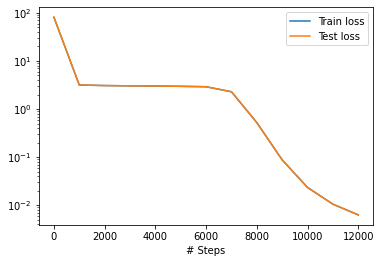

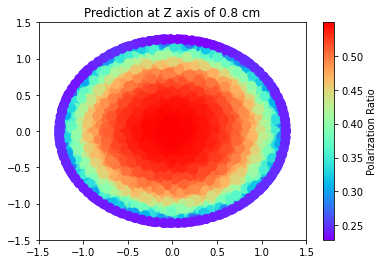

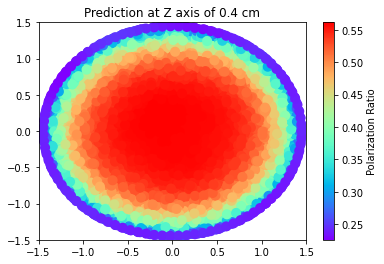

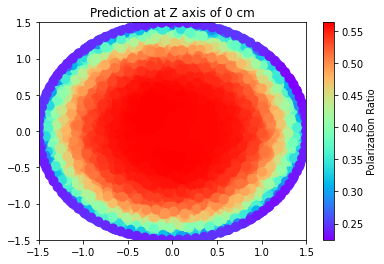

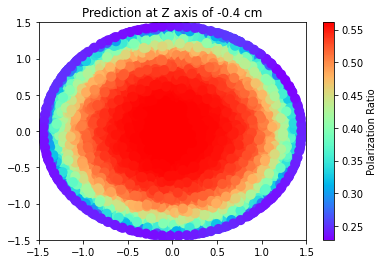

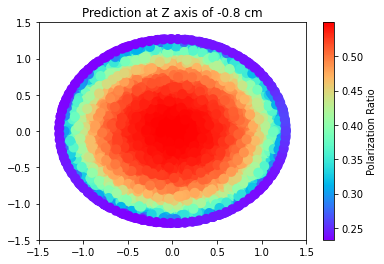

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Mar 21 20:38:19 2022
评估函数，面积网格化，然后绘图。比较的时候，可以比较两张图片的L2 error


@author: Administrator
"""

"""Backend supported: tensorflow.compat.v1"""
import deepxde as dde
import numpy as np
from deepxde.backend import tf
from scipy.special import gamma

#import mayavi.mlab as mlab
import matplotlib.pyplot as plt

from draw_counter import random_sphere_points, uniform_sample_points
from PIL import Image

## define parameters
D = 0.58 ## 扩散系数，cm2/s
Rop = 40
#Rrel = 17.5573
Rsd = 17.5573
Rwall = 2.564
q = 5 ## 减速因子
rcell = 1.5


# def fpde(x, y, int_mat):
#     """\int_theta D_theta^alpha u(x)"""
#     if isinstance(int_mat, (list, tuple)) and len(int_mat) == 3:
#         int_mat = tf.SparseTensor(*int_mat)
#         lhs = tf.sparse_tensor_dense_matmul(int_mat, y)
#     else:
#         lhs = tf.matmul(int_mat, y)
#     lhs = lhs[:, 0]
#     lhs *= gamma((1 - alpha) / 2) * gamma((3 + alpha) / 2) / (2 * np.pi ** 2)
#     x = x[: tf.size(lhs)]
#     rhs = (
#         2 ** alpha
#         * gamma(2 + alpha / 2)
#         * gamma((3 + alpha) / 2)
#         / gamma(3 / 2)
#         * (1 - (1 + alpha / 3) * tf.reduce_sum(x ** 2, axis=1))
#     )
#     return lhs - rhs

def bloch_pde(x_in, y_in):
    ''' x_in: (x,y,z) axis
        y_in: Pz polarization
    '''
    x = x_in[:, 0:1]
    y = x_in[:, 1:2]
    z = x_in[:, 2:3]
    
    dy_xx = dde.grad.hessian(y_in, x_in, i=0, j=0)
    dy_yy = dde.grad.hessian(y_in, x_in, i=1, j=1)
    dy_zz = dde.grad.hessian(y_in, x_in, i=2, j=2) # dy/dxidxj
    
    return -D*(dy_xx+dy_yy+dy_zz) + ((Rop+Rsd)/q+Rwall)*y_in - Rop/q

# def func(x):
#     return (np.abs(1 - np.linalg.norm(x, axis=1, keepdims=True) ** 2)) ** (
#         1 + alpha / 2
#     )

def func_boundary(x_in, Pz, numpy_X):
    x = x_in[:, 0:1]
    y = x_in[:, 1:2]
    z = x_in[:, 2:3]
    
    dPz_x = dde.grad.jacobian(Pz, x_in, i=0, j=0) # This is right
    dPz_y = dde.grad.jacobian(Pz, x_in, i=0, j=1)
    dPz_z = dde.grad.jacobian(Pz, x_in, i=0, j=2)
    
    return D/rcell*(x*dPz_x + y*dPz_y + z*dPz_z) + Pz*np.sqrt(1/2*np.abs(Rop*D))

geom = dde.geometry.Sphere([0, 0, 0], rcell)
#bc = dde.icbc.DirichletBC(geom, func_boundary, lambda _, on_boundary: on_boundary)

#bc = dde.icbc.RobinBC(geom, func_boundary, lambda _, on_boundary: on_boundary)
bc = dde.icbc.OperatorBC(geom, func_boundary, lambda _, on_boundary: on_boundary) # 函数调研下，operatorBC

# data = dde.data.FPDE(
#     geom,
#     fpde,
#     alpha,
#     bc,
#     [8, 8, 100],
#     num_domain=256,
#     num_boundary=1,
#     solution=func,
# )

data = dde.data.PDE(geom, bloch_pde, bc, num_domain=25000, num_boundary=3000)

net = dde.nn.FNN([3] + [30] * 4 + [1], "tanh", "Glorot normal")
# net.apply_output_transform(
#     lambda x, y: (1 - tf.reduce_sum(x ** 2, axis=1, keepdims=True)) * y
# )

model = dde.Model(data, net)
model.compile("adam", lr=1e-4)
#losshistory, train_state = model.train(epochs=8000, model_save_path='Bloch_Rop_v1')
losshistory, train_state = model.train(epochs=12000, model_save_path='./ckpt/Rop_v1')
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


#z_axis_list = [1.2, 0.8, 0.4, -0.4, -0.8, -1.2]
z_axis_list = [0.8, 0.4, 0, -0.4, -0.8]
for z_axis in z_axis_list:
    figure = plt.figure() 
    X = random_sphere_points(z= z_axis)
    y_pred = model.predict(X)[:, 0]
    np.save('./result/axes_{}'.format(z_axis), X)
    np.save('./result/pred_{}'.format(z_axis), y_pred)
    
    x_axis, y_axis = X[:, 0], X[:, 1]
    plt.scatter(x_axis, y_axis, s=50, c= y_pred, cmap='rainbow', linewidth=3)
    plt.colorbar(label="Polarization Ratio") 
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    plt.title('Prediction at Z axis of {0} cm'.format(z_axis))

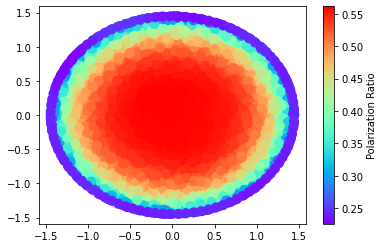

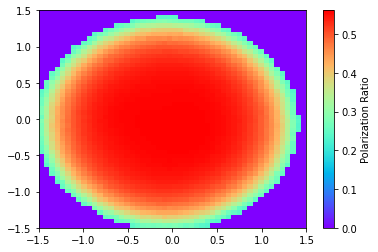

In [16]:
#x, y = X_data[:, 0], X_data[:, 1]
X = random_sphere_points(z= 0.4)
x = X[:, 0]
y = X[:, 1]
Pz = model.predict(X)[:, 0]
## 放到区间下，

num_space = 50
X_lim = np.linspace(-1.5, 1.5, num_space+1)
x_space = 3/num_space
Y_lim = np.linspace(-1.5, 1.5, num_space+1)
y_space = 3/num_space

Pz_dist = np.zeros((num_space, num_space))
Pz_dist_num = np.zeros((num_space, num_space))

for point_idx in range(len(x)):
    Pz_idx = int((x[point_idx]+1.5)/x_space-1)
    Pz_idy = int((y[point_idx]+1.5)/y_space-1)
    
    Pz_dist[Pz_idx, Pz_idy] += Pz[point_idx]
    Pz_dist_num[Pz_idx, Pz_idy] += 1

Pz_dist_pred = Pz_dist/(Pz_dist_num+1e-6)


plt.scatter(x, y, s=50, c= Pz, cmap='rainbow', linewidth=3)
plt.colorbar(label="Polarization Ratio") 
plt.figure()

x_axis = (X_lim+x_space/2)[:-1]
y_axis = (Y_lim+y_space/2)[:-1]
xx, yy = np.meshgrid(x_axis, y_axis)


plt.pcolormesh(xx, yy, Pz_dist_pred, cmap='rainbow')
plt.colorbar(label="Polarization Ratio") 
#plt.colorbar(label="Polarization Ratio") 
plt.show()
    
#plt.imshow(Pz_dist_pred)    
# Pz = y_pred
# num_space = 30
# X_lim = np.linspace(-1.5, 1.5, num_space+1)
# x_space = 3/num_space
# Pz_dist = np.zeros(num_space) ## Pz value add
# Pz_space_num = np.zeros(num_space) ## Pz number

# for x_idx in range(len(x)):
#       Pz_idx = int((x[x_idx]+1.5)/x_space-1)
#       Pz_dist[Pz_idx] += Pz[x_idx]
#       Pz_space_num[Pz_idx] += 1

# Pz_density = Pz_dist/Pz_space_num  
# plt.figure()
# plt.plot(Pz_density)

In [18]:
import pandas as pd

file_idx = '0.4'
filename = './result/COMSOL_Rop_40/z{0}.csv'.format(file_idx)
df = pd.read_csv(filename, header=9, names=['x', 'y', 'z', 'Pz'])
## (x, y, z) u1, 20796*4

x = np.asarray(df['x'])
y = np.asarray(df['y'])
z = np.asarray(df['z'])
Pz = np.asarray(df['Pz'])


num_space = 50
X_lim = np.linspace(-1.5, 1.5, num_space+1)
x_space = 3/num_space
Y_lim = np.linspace(-1.5, 1.5, num_space+1)
y_space = 3/num_space

Pz_dist_COMSOL = np.zeros((num_space, num_space))
Pz_dist_num = np.zeros((num_space, num_space))

for point_idx in range(len(x)):
    Pz_idx = int((x[point_idx]+1.5)/x_space-1)
    Pz_idy = int((y[point_idx]+1.5)/y_space-1)
    
    Pz_dist_COMSOL[Pz_idx, Pz_idy] += Pz[point_idx]
    Pz_dist_num[Pz_idx, Pz_idy] += 1

Pz_dist_COMSOL = Pz_dist_COMSOL/(Pz_dist_num+1e-6)

In [4]:
def mask_radius(rcell, z, l):
    r_z = np.sqrt(rcell**2 - z**2)
    mask_z = np.zeros()
    

(1001,)

In [19]:
np.sum(np.abs(Pz_dist_COMSOL - Pz_dist_pred))

7.903231702993887

In [20]:
np.mean(np.abs(Pz_dist_COMSOL - Pz_dist_pred))

0.003161292681197555

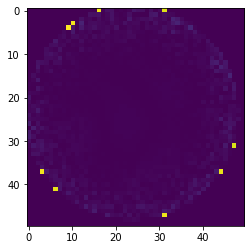

In [21]:
Pz_dist_error = np.abs(Pz_dist_COMSOL - Pz_dist_pred)

plt.imshow(Pz_dist_error)

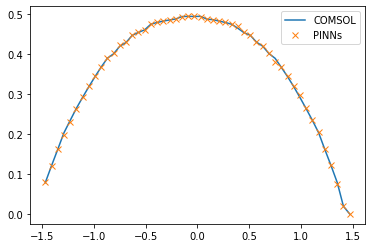

In [29]:
Pz_COMSOL_x = np.mean(Pz_dist_COMSOL, axis=1)
Pz_pred_x = np.mean(Pz_dist_pred, axis = 1)
x_plot = (X_lim + x_space/2)[:-1]

plt.plot(x_plot, Pz_COMSOL_x, label='COMSOL')
plt.plot(x_plot, Pz_pred_x, marker='x', linestyle='', label='PINNs')
plt.legend()